In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from skimage.color import lab2rgb
from skimage.color import rgb2lab

In [2]:
data = pd.read_csv('colour-data.csv')
X_array = data[['R', 'G', 'B']]/255
X = np.asarray(X_array, dtype=np.float32)
Y = data['Label']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.330)

In [4]:
model_rgb = GaussianNB()
model_rgb.fit(X_train, y_train)

GaussianNB()

In [5]:
print("Training score: %g\nValidation score: %g" % (model_rgb.score(X_train, y_train), model_rgb.score(X_test, y_test)))

Training score: 0.557067
Validation score: 0.53681


In [6]:
COLOUR_RGB = {
    'red': (255, 0, 0),
    'orange': (255, 114, 0),
    'yellow': (255, 255, 0),
    'green': (0, 230, 0),
    'blue': (0, 0, 255),
    'purple': (187, 0, 187),
    'brown': (117, 60, 0),
    'pink': (255, 187, 187),
    'black': (0, 0, 0),
    'grey': (150, 150, 150),
    'white': (255, 255, 255),
}
name_to_rgb = np.vectorize(COLOUR_RGB.get, otypes=[np.uint8, np.uint8, np.uint8])

def plot_predictions(model, lum=71, resolution=256):
    """
    Create a slice of LAB colour space with given luminance; predict with the model; plot the results.
    """
    wid = resolution
    hei = resolution
    n_ticks = 5

    # create a hei*wid grid of LAB colour values, with L=lum
    ag = np.linspace(-100, 100, wid)
    bg = np.linspace(-100, 100, hei)
    aa, bb = np.meshgrid(ag, bg)
    ll = lum * np.ones((hei, wid))
    lab_grid = np.stack([ll, aa, bb], axis=2)

    # convert to RGB for consistency with original input
    X_grid = lab2rgb(lab_grid)

    # predict and convert predictions to colours so we can see what's happening
    y_grid = model.predict(X_grid.reshape((wid*hei, 3)))
    pixels = np.stack(name_to_rgb(y_grid), axis=1) / 255
    pixels = pixels.reshape((hei, wid, 3))

    # plot input and predictions
    plt.figure(figsize=(10, 5))
    plt.suptitle('Predictions at L=%g' % (lum,))
    plt.subplot(1, 2, 1)
    plt.title('Inputs')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.ylabel('B')
    plt.imshow(X_grid.reshape((hei, wid, 3)))

    plt.subplot(1, 2, 2)
    plt.title('Predicted Labels')
    plt.xticks(np.linspace(0, wid, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.yticks(np.linspace(0, hei, n_ticks), np.linspace(-100, 100, n_ticks))
    plt.xlabel('A')
    plt.imshow(pixels)

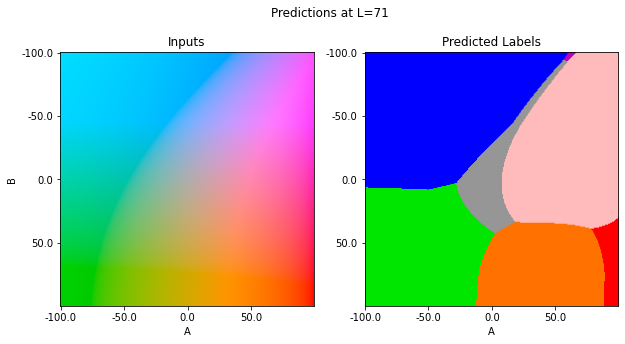

In [7]:
plot_predictions(model_rgb)

In [8]:
def convert(X):
    X.reshape(1,-1,3)
    X = rgb2lab(X)
    X.reshape(-1,3)
    return X


In [9]:
model_LAB = make_pipeline(
    FunctionTransformer(convert),
    GaussianNB()
)
model_LAB.fit(X_train,y_train)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function convert at 0x7f947474e0d0>)),
                ('gaussiannb', GaussianNB())])

In [10]:
print("Training score: %g\nValidation score: %g" % (model_LAB.score(X_train, y_train), model_LAB.score(X_test, y_test)))

Training score: 0.617158
Validation score: 0.595859


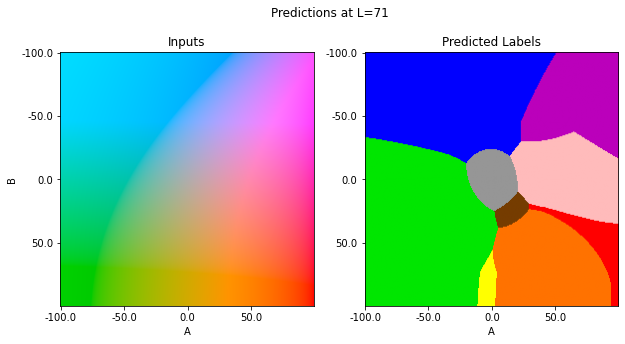

In [11]:
plot_predictions(model_LAB)